# Task 1

### Pretask question

Dataset: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

**The problem/goal:**

To be able to accurately determine the weather in the following days. This is important, as many people in India commute to places using motorcyles, which lack protection from the elements. By being well-informed about the weather, individuals are able to better prepare for the weather during their commute.

**Why Sequence Models are needed for this problem:**

Unlike traditional models, Sequence models don't assume that datapoints are independent. This means that sequence models are able to capture the relationships between the datapoints over time. This is important in time series data (such as the dataset that I chose), where the value of a parameter at a given day is often influenced by the values on previous days. For instance, temperature tends to depend on previous weather conditions, such as humidity, pressure, or wind speed. Therefore, by having a model that can understand these dependenies, we are able to have a more accurate response.

**RNN Framework:**

I will use PyTorch for building the building the RNN frameworks

## Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import kagglehub
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

## EDA

### Understanding the Problem and Data

**The goal:**

Stated above

**Variables in the dataset**


*   date
  *   date the weather data was captured
  *   text (DateTime)
*   meantemp
  *   the mean temperature averaged out from multiple 3 hour intervals in a day
  *   numerical
*   humidity
  *   Humidity value for the day (units are grams of water vapor per cubic meter volume of air).
  *   numerical
*   wind_speed
  *   Wind speed measured in kmph.
  *   numerical
*   meanpressure
  *   Pressure reading of weather (measure in atm)
  *   numerical

### Importing and Inspeting the Data

In [ ]:
path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

csv_path = os.path.join(path, "DailyDelhiClimateTrain.csv")

df = pd.read_csv(csv_path)

df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
# relates the features to their datatypes
df.dtypes

,0
date,object
meantemp,float64
humidity,float64
wind_speed,float64
meanpressure,float64


### Handling Missing Data

In [ ]:
# which columns have a missing value in the dataset?
df.isnull().any(axis=0)

,0
date,False
meantemp,False
humidity,False
wind_speed,False
meanpressure,False


In [ ]:
# number of features in the dataset
df.shape[1]

5

In [ ]:
# proportion of missing values (for this case, since there are no missing values, all answers will be 0) in train dataset
df.isna().sum()/df.shape[0]

,0
date,0.0
meantemp,0.0
humidity,0.0
wind_speed,0.0
meanpressure,0.0


### Exploring Data Characteristics

In [ ]:
# statistics of the dataset
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


### Data Transformation

In [ ]:
df['date'] = pd.to_datetime(df['date'])

# Check the range of years
min_year = df['date'].dt.year.min()
max_year = df['date'].dt.year.max()

# We can see that the years span from 2013 to 2017, and therefore, it is important that we encode the years as well
print("Min year", min_year)
print("Max year", max_year)

Min year 2013
Max year 2017


In [ ]:
# create column for year, month, and day in the dataset
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [ ]:
# scale data
scaler = MinMaxScaler()

df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = scaler.fit_transform(
    df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
)

In [ ]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day
0,2013-01-01,0.122271,0.820957,0.000000,0.132603,2013,1,1
1,2013-01-02,0.042795,0.907591,0.070583,0.132881,2013,1,2
2,2013-01-03,0.035662,0.849835,0.109743,0.132994,2013,1,3
3,2013-01-04,0.081514,0.668867,0.029212,0.132799,2013,1,4
4,2013-01-05,0.000000,0.847910,0.087636,0.132712,2013,1,5


### Variance Inflation Factor

In [ ]:
chosenFeatures = ['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'year', 'month', 'day']

# Only choose specific features to find variance on
X = df[chosenFeatures]

# Compute VIF
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif.round(2))

       features  VIF Factor
0      meantemp       12.80
1      humidity       14.52
2    wind_speed        3.93
3  meanpressure       32.84
4          year       79.15
5         month        4.94
6           day        4.20


### Visualizations

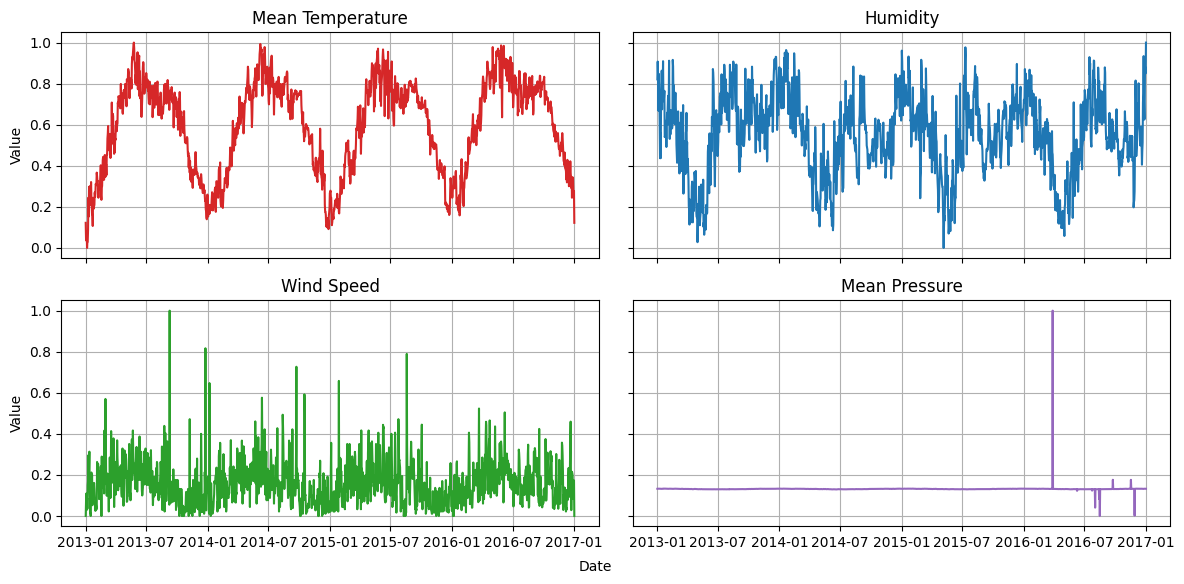

In [ ]:
# Set up a compact 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# Climate variable plots
axs[0, 0].plot(df['date'], df['meantemp'], color='tab:red')
axs[0, 0].set_title('Mean Temperature')

axs[0, 1].plot(df['date'], df['humidity'], color='tab:blue')
axs[0, 1].set_title('Humidity')

axs[1, 0].plot(df['date'], df['wind_speed'], color='tab:green')
axs[1, 0].set_title('Wind Speed')

axs[1, 1].plot(df['date'], df['meanpressure'], color='tab:purple')
axs[1, 1].set_title('Mean Pressure')

for ax in axs.flat:
  ax.set_ylabel('Value')
  ax.grid(True)
  ax.label_outer()

fig.text(0.5, 0.04, 'Date', ha='center')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


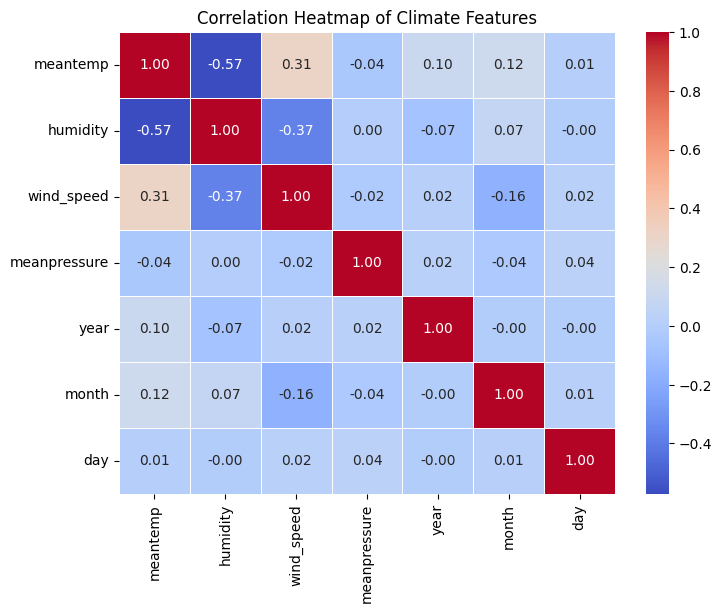

In [ ]:
df_subset = df[chosenFeatures]

# Compute correlation matrix
corr_matrix = df_subset.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Climate Features")
plt.show()

# As we can see below, there are some variables that are highly corrleated

### Findings

The goal of this analysis was to explore a climate time series dataset, and identify patterns in key weather variables. We used line plots and heatmaps in order to understand the correlations between features, and to understand how each feature changes over time. Since some features show multicollinearity, this suggests that RNNs would be appropriate. One limitation that I faced was that this dataset is limited to only Delhi, and therefore can not be generalized to other regions in India. Next steps can be for me to find datasets for other regions in India, so I can add the ability for other regions to utilize this model.

### Part 1

In [ ]:
num_hidden_units = 64
output_dim = 1

# Build RNN model
# There are 2 layers. The first layer as 64 neurons. The input to this layer is a sequence of vectors.
# The second layer, the Dense layer, is 1 output neuron. It maps the hidden state from RNN to a predicted value
# I am using tanh activation function
rnn_model = Sequential([
  SimpleRNN(num_hidden_units, activation='tanh', return_sequences=False),
  Dense(output_dim)
])

# I am using MSE for the performance measure
rnn_model.compile(optimizer='adam', loss='mse')

rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
sequence_length = 30

df = df.drop('date', axis=1)

# all the features in the dataset
X_all = df.values
# only the meantemp values
y_all = df.iloc[:, 0].values

# train, test, validation split
total_samples = len(X_all) - sequence_length
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.1)
test_size = total_samples - train_size - val_size


In [ ]:
# function to a subset of data from the dataframe
# allows to easily get sequences for the train, validation, and test datasets
def make_datasets(start_index, end_index, shuffle=False):
  return tf.keras.utils.timeseries_dataset_from_array(
    data=X_all[start_index:end_index],
    targets=y_all[start_index + sequence_length:end_index + sequence_length],
    sequence_length=sequence_length,
    batch_size=32,
    shuffle=shuffle
  )

train_dataset = make_datasets(
  start_index=0,
  end_index=train_size
)

val_dataset = make_datasets(
  start_index=train_size,
  end_index=train_size + val_size
)

test_dataset = make_datasets(
  start_index=train_size + val_size,
  end_index=train_size + val_size + test_size
)

print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [ ]:
# fits model to dataset
rnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=5
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1249 - val_loss: 0.0314
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0550 - val_loss: 0.0676
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0524 - val_loss: 0.0670
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0531 - val_loss: 0.0647
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0533 - val_loss: 0.0644


In [ ]:
loss = rnn_model.evaluate(test_dataset)
print("Test MSE:", loss)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0593 
Test MSE: 0.04950393736362457


In [ ]:
val_loss = rnn_model.evaluate(val_dataset)
print("Validation MSE:", val_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0538
Validation MSE: 0.06441638618707657


## Part 2

In [ ]:
# Build GRU model
# There are 2 layers. The first layer as 64 neurons. The input to this layer is a sequence of vectors.
# The second layer, the Dense layer, is 1 output neuron. It maps the hidden state from RNN to a predicted value
# I am using tanh activation function
gru_model = Sequential([
  GRU(num_hidden_units, activation='tanh', return_sequences=False),
  Dense(output_dim)
])

# I am using MSE for the performance measure
gru_model.compile(optimizer='adam', loss='mse')

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build LSTM model
# There are 2 layers. The first layer as 64 neurons. The input to this layer is a sequence of vectors.
# The second layer, the Dense layer, is 1 output neuron. It maps the hidden state from RNN to a predicted value
# I am using tanh activation function
lstm_model = Sequential([
  LSTM(num_hidden_units, activation='tanh', return_sequences=False),
  Dense(output_dim)
])

# I am using MSE for the performance measure
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fits model to dataset
gru_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=5
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0704 - val_loss: 0.0491
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0508 - val_loss: 0.0735
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0505 - val_loss: 0.0688
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0505 - val_loss: 0.0689
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0505 - val_loss: 0.0688


In [ ]:
# fits model to dataset
lstm_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=5
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1485 - val_loss: 0.0630
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0470 - val_loss: 0.0814
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0476 - val_loss: 0.0793
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0475 - val_loss: 0.0784
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0475 - val_loss: 0.0783


In [ ]:
# performance measures for GRU and LSTM

loss_GRU = gru_model.evaluate(test_dataset)
print("GRU Test MSE:", loss_GRU)

val_loss_GRU = gru_model.evaluate(val_dataset)
print("GRU Validation MSE:", val_loss_GRU)

loss_LSTM = lstm_model.evaluate(test_dataset)
print("LSTM Test MSE:", loss_LSTM)

val_loss_LSTM = lstm_model.evaluate(val_dataset)
print("LSTM Validation MSE:", val_loss_LSTM)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0553
GRU Test MSE: 0.04615682736039162
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0577
GRU Validation MSE: 0.06883309781551361
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0477
LSTM Test MSE: 0.03990035504102707
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0662
LSTM Validation MSE: 0.07834450155496597


1. GRU Had the lowest Test MSE
*   This is likely due to the fact that GRU was able to better generalize on the data. This is likely due to the fact that GRU models are designed to handle the vanishing gradient problem. Since GRU models are simplier than LSTM models, they are better able to converge when given datasets which are not very large (my dataset is not very large).

2. LSTM had the lowest Validation MSE
*   LSTM fit the validation dataset better. This is likely due to the fact that their more complex structure (than compared to GRU and basic RNN) allows them to better understand temporal dependencies.

3. RNN was outperformed in both validation and test MSEs when compared to GRU and LSTM
*   This is likely because of the fact that basic RNNs tend to struggle with learning long-term temporal dependencies. Unlike GRU and LSTM, basic RNN models are not able to deal with the vanishing gradient problem well. As a result, they basic RNN models are likely to have a worse performance than compared to GRU and LSTM models.




## Part 3

It is possible to use the traditional feed-forward network to solve the same problem. This is possible if we were to convert the sequential data into a format such that it can be input into the FNN at a fixed size. We can do this by:
  *   Choosing a fixed number of past time steps (sequence_length).
  *   If there are n features, there will be n inputs for the FNN, where each input is a specific feature from the dataset. The input size for each input is sequence_length, which will be the length of the sequence of past observations of that feature. The output is the value predicted for the next day after the sequence.
    * ex: If the sequence_length = 30, each input to the FNN would be the 30 previous observations, and the output would be the value for the next day (day 31).

This way, the relationships between the features over time is kept.

The downside of this is that the FNN only learns the patterns for that fixed window in time. And since FNNs treat each input independently, and do not have a way to preserve information across time steps, FNNs struggle to capture long-term relationships past the fixed window.